In [1]:
from PIL import Image
from numpy import *
from pylab import *

In [2]:
from scipy.misc import imresize
import graphcut
graphcut = reload(graphcut)
from pygraph.classes.digraph import digraph
from pygraph.algorithms.minmax import maximum_flow
import bayes

In [3]:
im = array(Image.open('empire.jpg'))
im = imresize(im, 0.07, interp='bilinear')
size = im.shape[:2]

In [4]:
labels = zeros(size)
labels[3:18, 3:18] = -1
labels[-18:-3, -18:-3] = 1

In [5]:
def build_bayes_graph(im, labels, sigma=1e-2, kappa=2):
    """ Build a graph from 4-neighborhood of pixels.
    Foregraound and background is determined from
    labels (1 for foreground, -1 for background, 0 othewise)
    and is modeled with naive Bayes classifiers. """

    m, n = im.shape[:2]

    # RGB vector version (one pixel per row)
    vim = im.astype('float')
    vim = vim.reshape((-1, 3))

    # RGB for foreground and background
    foreground = im[labels == 1].reshape((-1, 3))
    background = im[labels == -1].reshape((-1, 3))
    train_data = [foreground, background]

    # train naive Bayes classifier
    bc = bayes.BayesClassifier()
    bc.train(train_data, labels)

    # get probabilities for all pixels
    bc_lables, prob = bc.classify(vim)
    prob_fg = prob[0]
    prob_bg = prob[1]

    # create graph with m*n+2 nodes
    gr = digraph()
    gr.add_nodes(range(m*n+2))

    source = m*n  # second to last is source
    sink = m*n+1  # last node is sink

    # normalize
    pos = m*n/2-100
    for i in range(vim.shape[0]):
        vim[i] = vim[i] / linalg.norm(vim[i])

    # go through all nodes and add edges
    for i in range(m*n):
        # add edge from source
        if (prob_fg[i]>prob_bg[i]):
            gr.add_edge((source, i), wt=((prob_fg[i]-prob_bg[i])/(prob_fg[i] + prob_bg[i])))
        else:
            # add edge to sink
            gr.add_edge((i, sink), wt=((prob_bg[i]-prob_fg[i])/(prob_fg[i] + prob_bg[i])))
            
        # add edges to neighbors
        if i % n != 0:  # left exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i-1])**2)/sigma)
            gr.add_edge((i, i-1), wt=edge_wt)
        if (i+1) % n != 0:  # right exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i+1])**2)/sigma)
            gr.add_edge((i, i+1), wt=edge_wt)
        if i//n != 0:  # up exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i-n])**2)/sigma)
            gr.add_edge((i, i-n), wt=edge_wt)
        if i//n != m-1:  # down exists
            edge_wt = kappa*exp(-1.0*sum((vim[i] - vim[i+n])**2)/sigma)
            gr.add_edge((i, i+n), wt=edge_wt)
            
    return gr


In [6]:
import time

In [9]:
# the original version from Chapter-9
start = time.time()
g = graphcut.build_bayes_graph(im, labels, kappa=1)
res2 = graphcut.cut_graph(g, size)
end = time.time()
print end - start, 's'

411.63883996 s


In [7]:
# Reduced version. Each pixel has only one link either to source or to sink
start = time.time()
g = build_bayes_graph(im, labels, kappa=1)
res = graphcut.cut_graph(g, size)
end = time.time()
print end - start, 's'

133.951222181 s


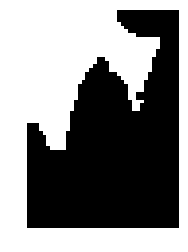

In [8]:
figure()
graphcut.show_labeling(im, labels)

figure()
subplot(1, 2, 1)
imshow(res2)
gray()
axis('off')

subplot(1, 2, 2)
imshow(res)
gray()
axis('off')

show()